In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join, exists
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import json
from PIL import Image

# Toydata

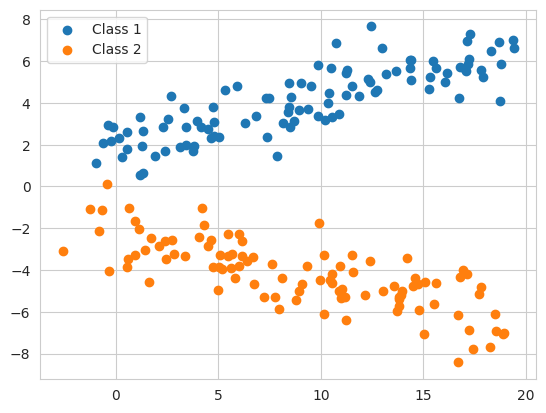

In [2]:
# Generate data for two classes from 4 clusters
n_samples = 10 # pro cluster - divide by 2 for n_samples per class
n_clusters = 10 # Number of Clusters along the decision border
dist_cluster = 2 # distance of clusters
pos_cls = []
neg_cls = []

for i in range(n_clusters):
    mean_pos_cls = [i * dist_cluster, 2  + 0.5 * i]
    mean_neg_cls = [i * dist_cluster, -2 - 0.5 * i]
    cov = [[1, 0], [0, 1]]

    pos_cluster = np.random.multivariate_normal(mean_pos_cls, cov, n_samples)
    neg_cluster = np.random.multivariate_normal(mean_neg_cls, cov, n_samples)
    pos_cls.append(pos_cluster)
    neg_cls.append(neg_cluster)

data_pos = np.concatenate(pos_cls, axis=0)
data_neg = np.concatenate(neg_cls, axis=0)

# Plot the clusters

fig, ax = plt.subplots()
ax.scatter(data_pos[:, 0], data_pos[:, 1], label='Class 1')
ax.scatter(data_neg[:, 0], data_neg[:, 1], label='Class 2')

ax.legend()
plt.show()

# Mean / STD convergence

In [3]:
def shuffle(v):
    ids = np.arange(len(v))
    np.random.shuffle(ids)
    return v[ids]

def auc(values):
    v = np.sum(values, axis=1) / values.shape[1]
    return np.squeeze(v)

def mean_std_curves(inpt):
    mean_develop = [np.median(inpt[:i]) for i in range(1, len(inpt) + 1)]
    # median_develop = [np.median(inpt[:i]) for i in range(1, len(inpt) + 1)]
    std_develop = [np.std(inpt[:i]) for i in range(1, len(inpt) + 1)]
    return mean_develop, std_develop

def plot(ax, points, trajectories, twin, color, title):
    # ax.set_ylabel("mean")
    ax.set_xlabel("eval run")
    ax.scatter(range(len(points)), points, c="r", s=9, alpha=0.3)
    ax.grid()
    if twin:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    for line in trajectories:
        ax2.plot(line, c=color, alpha=0.3)
    ax2.grid()
    ax.set_title(title)

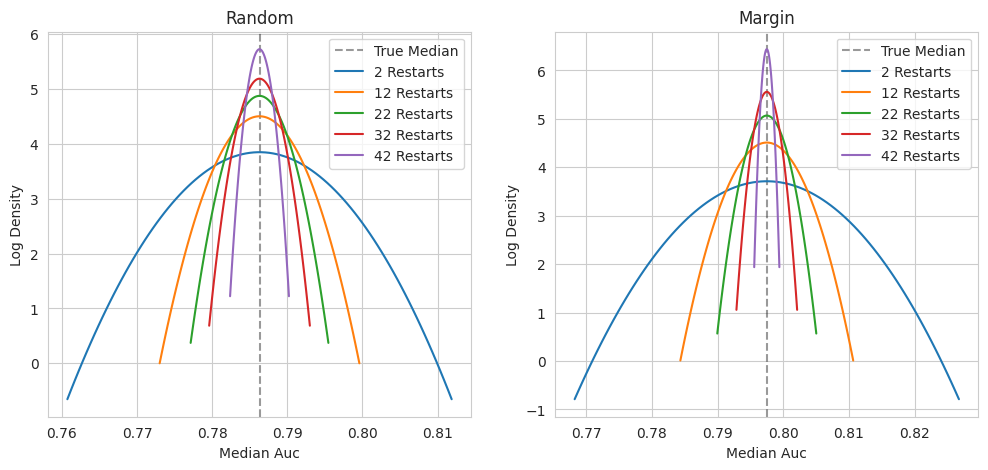

In [12]:
import scipy.stats as stats

def do_box(ax, file, title):
    accuracies = pd.read_csv(file, header=0, index_col=0)
    values = auc(accuracies.values.T)
    true_median = np.median(values)
    medians = []
    sizes = []
    for size in range(2, len(values), 5):
        current = []
        for _ in range(50):
            v = shuffle(values)[:size]
            current.append(np.median(v))
        medians.append(current)
        sizes.append(size)
    ax.axhline(true_median, label="True Median", linestyle="--", c="black", alpha=0.4)
    ax.boxplot(medians, widths=3, positions=sizes)
    ax.set_xlabel("# of Restarts")
    ax.set_ylabel("Median Auc")
    ax.set_title(title)
    ax.legend()

def do_normal(ax, file, title):
    accuracies = pd.read_csv(file, header=0, index_col=0)
    values = auc(accuracies.values.T)
    true_median = np.median(values)
    ax.axvline(true_median, label="True Median", linestyle="--", c="black", alpha=0.4)
    for size in range(2, len(values), 10):
        current = []
        for _ in range(50):
            v = shuffle(values)[:size]
            current.append(np.median(v))
        std = np.std(current)
        x = np.linspace(true_median - 3*std, true_median + 3*std, 100)
        ax.plot(x, stats.norm.logpdf(x, true_median, std), label=f"{size} Restarts")
    ax.set_xlabel("Median Auc")
    ax.set_ylabel("Log Density")
    ax.set_title(title)
    # ax.set_yscale("log")
    ax.legend()

np.random.seed(2023)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# do_box(ax1, "runs/Splice/RandomAgent/accuracies.csv", "Random")
# do_box(ax2, "runs/Splice/MarginScore/accuracies.csv", "Margin")
do_normal(ax1, "runs/Splice/RandomAgent/accuracies.csv", "Random")
do_normal(ax2, "runs/Splice/MarginScore/accuracies.csv", "Margin")

plt.show()
plt.close(fig)

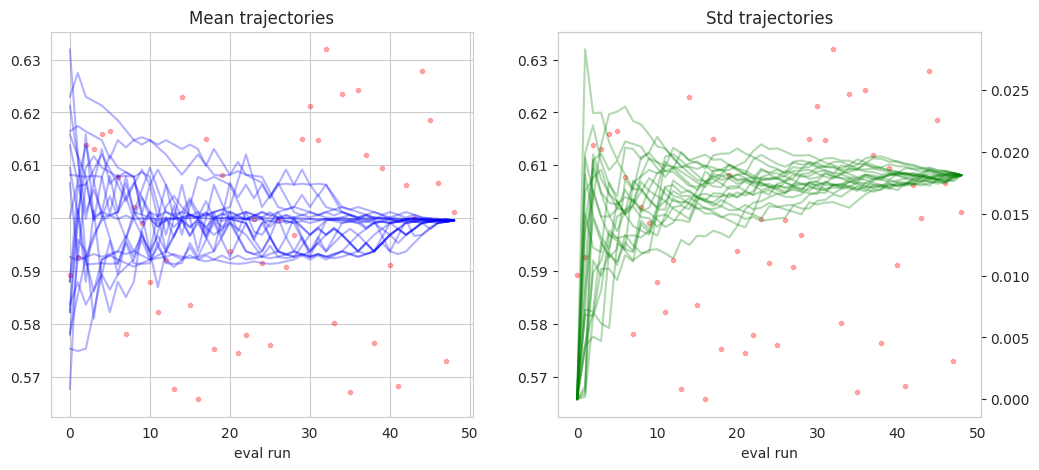

In [5]:
file = "runs/Cifar10Encoded/RandomAgent/accuracies.csv"
accuracies = pd.read_csv(file, header=0, index_col=0)
values = auc(accuracies.values.T)
mean = []
std = []
for _ in range(20):
    v = shuffle(values)
    m, s = mean_std_curves(v)
    mean.append(m)
    std.append(s)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot(ax1, values, mean, False, "b", "Mean trajectories")
plot(ax2, values, std, True, "g", "Std trajectories")
plt.show()
plt.close(fig)

# Raytune result recovery

In [6]:
file = "raytune_output/Splice/pretext/evaluate_pretext_config_2023-03-30_15-20-46/experiment_state-2023-03-30_15-20-46.json"
with open(file, 'r') as f:
    json_log = json.load(f)

runs = []
for r in json_log["checkpoints"]:
    runs.append(json.loads(r))

FileNotFoundError: [Errno 2] No such file or directory: 'raytune_output/Splice/pretext/evaluate_pretext_config_2023-03-30_15-20-46/experiment_state-2023-03-30_15-20-46.json'

In [ ]:
df = pd.DataFrame(columns=["acc", "hidden", "feature_dim", "batch_size", "lr", "weight_decay",
                           "lr_sched_decay", "temperature", "gauss_scale"])
for idx, run in enumerate(runs):
    if '_last_result' in run and 'acc' in run["_last_result"]:
        c = run["config"]
        hidden = [c["h1"]]
        if c["h2"] > 0:
            hidden.append(c["h2"])
        if c["h3"] > 0:
            hidden.append(c["h3"])
        df = pd.concat([df, pd.DataFrame({
            "acc": run["_last_result"]["acc"],
            "hidden": str(hidden),
            "feature_dim": c["feature_dim"],
            "batch_size": c["batch_size"],
            "lr": c["lr"],
            "weight_decay": c["weight_decay"],
            "lr_sched_decay": c["lr_scheduler_decay"],
            "temperature": c["temperature"],
            "gauss_scale": c["gauss_scale"],
        }, index=[idx])])

In [ ]:
out_file = "raytune_output/DNA/pretext/evaluate_pretext_config_2023-03-30_15-20-47/result.csv"
df.to_csv(out_file)

# Plotting all Upper bound runs

In [ ]:
dataset = "runs/DNA"

all_img_files = []
upper_bound_folder = join(dataset, "UpperBound")
for run in os.listdir(upper_bound_folder):
    img_file = join(upper_bound_folder, run, "learning_curves.jpg")
    if exists(img_file):
        all_img_files.append(img_file)

cols = 3
rows = int(np.ceil(len(all_img_files) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(20,15))
i = 0
for row in range(rows):
    for col in range(cols):
        if i < len(all_img_files):
            with Image.open(all_img_files[i]) as im:
                axes[row, col].imshow(im)
                i += 1
# fig.show()